<h2> Лекция 2. Элементарные методы анализа временных рядов

In [161]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from scipy.stats import boxcox
%matplotlib inline

Загружаем данные по 2 рядам

In [162]:
sales_of_company_x = pd.read_csv("Series/monthly-sales-of-company-x-jan-6.csv")
mean_monthly_temp = pd.read_csv("Series/mean-monthly-air-temperature-deg.csv")
#df = pd.read_csv("Series/mean-monthly-air-temperature-deg.csv")
#df = pd.read_csv("Series/mean-monthly-air-temperature-deg.csv")
#df.rename(columns = {'Deg':'Count'}, inplace = True )

<h3> Построим графики рядов

In [163]:
all_series = {
    "Monthly sales of company X": sales_of_company_x["Count"],
    "Mean monthly air temperature (Deg. F) Nottingham Castle": mean_monthly_temp["Deg"]
}

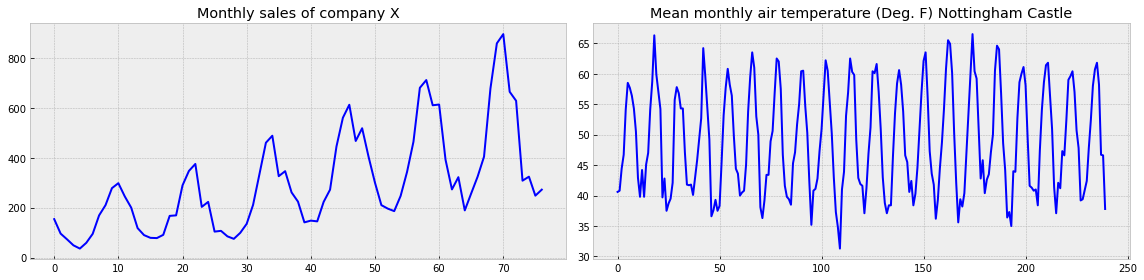

In [164]:
with plt.style.context('bmh'):
    plt.figure(figsize=(16, 4))
    layout = (1, 2)
    for i, key in enumerate(all_series.keys()):
        x = i % 2
        y = int((i - x) / 2)
        
        ts_ax = plt.subplot2grid(layout, (y, x))
        all_series[key].plot(ax=ts_ax, color='blue')
        ts_ax.set_title(key)
        
    plt.tight_layout()

In [165]:
# Функция для построения графиков автокорреляции и частичной автокорреляция
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    #test_stationarity2(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (4, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        #print((i+1),'.',key)
        ts_ax.set_title((str(i+1)) + '. ' + key + ' (Original)')
        #print((i+1),'.',key)
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05, method='ywm')

        plt.tight_layout()
    return

<h3> Рассчитаем  p-value и построим графики коррелляции по 2 рядам

Results of Dickey-Fuller Test: p-value
1 . Monthly sales of company X
0.9888894205170052
2 . Mean monthly air temperature (Deg. F) Nottingham Castle
0.016989030222608986


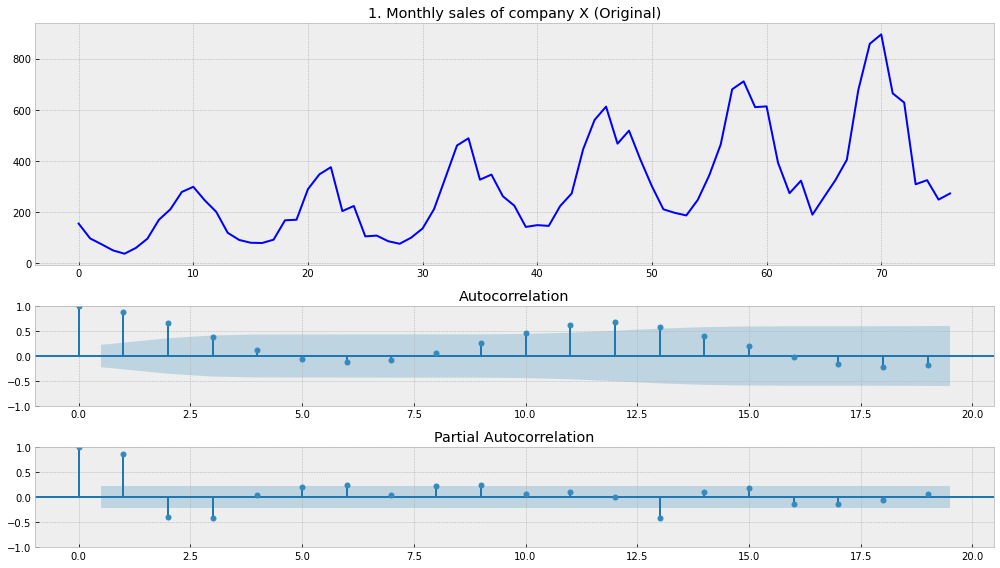

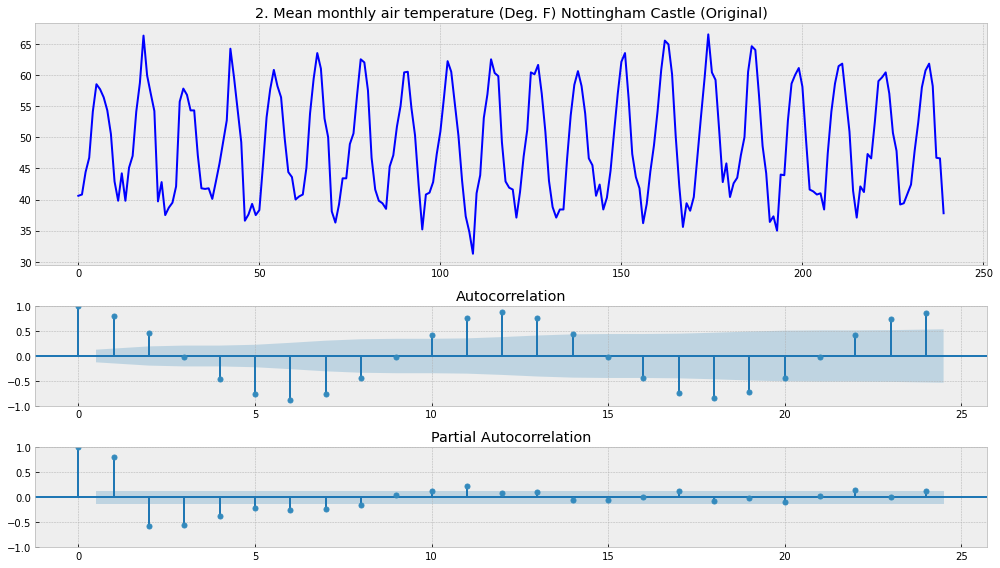

In [166]:
df0=[]
print('Results of Dickey-Fuller Test: p-value')
for i, key in enumerate(all_series.keys()):
    series = all_series[key]
    print((i+1),'.',key)
    #print('Results of Dickey-Fuller Test:')
    dftest = adfuller(series, autolag='AIC')
    dfoutput = pd.Series(dftest[1], index=['p-value'])
    print(dfoutput[0])
    df =round(dftest[1],4)
    df0.append(df)
    tsplot(series)
#print('p-value  по 6 рядам:',df0)

Первый ряд является нестационарным, второй стационарным

<h3> Построим скользящие средние для 2 рядов

In [167]:
def moving_average(series, n):
    if not isinstance(series, pd.Series):
        series = pd.Series(series)
    return series.rolling(n).mean()
def predict(series, N, n_pred):
    new_series = series.copy()
    for _ in range(n_pred):
        new_series = new_series.append(pd.Series([new_series[-N:].mean()]), ignore_index=True)
    return new_series

The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


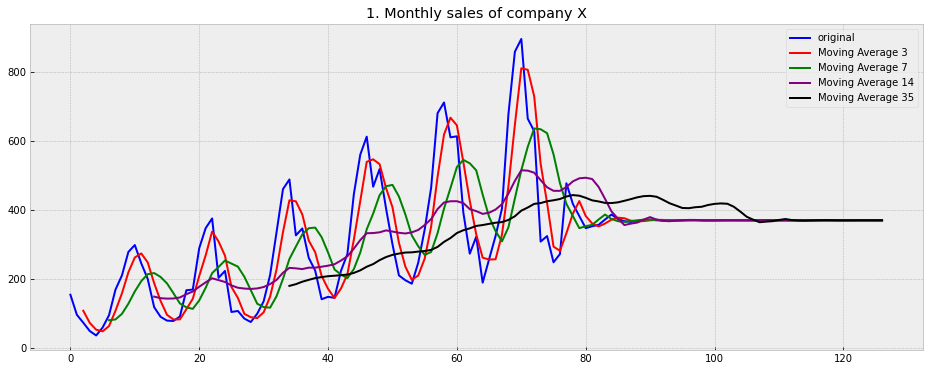

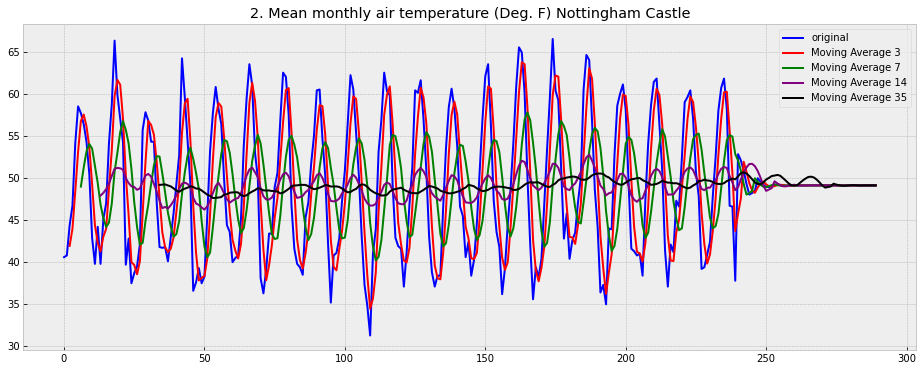

In [168]:
for i, key in enumerate(all_series.keys()):
    series_pred = predict(all_series[key], 7, 50)
    windows = [3,7,14,35]
    colors = ['red', 'green', 'purple', 'black']
    with plt.style.context('bmh'):
        plt.figure(figsize=(16, 6))
        plt.plot(series_pred, color='blue',label='original')
        plt.title(str(i+1) + '. ' + key)
        for i in range(len(windows)):
            ser = moving_average(series_pred, windows[i])
            plt.plot(ser, color=colors[i], linewidth='2', label='Moving Average {}'.format(windows[i]))
        plt.legend()

Модификацией скользящей средней (MA) является взвешенная скользящая средняя (WMA).
Обычно чем ближе измерение к прогнозируемому - тем больше его вес. Возьмем веса [1,1,2,3,5,8,13],
а также добавим экспоненциальное скользящее среднее (EMA).

In [169]:
def weighted_moving_average(series, n, weights):
    if not isinstance(weights, np.ndarray):
        weights = np.array(weights)
    if not isinstance(series, pd.Series):
        series = pd.Series(series)
    wma = series.rolling(n).apply(lambda s: (s * weights).sum() / weights.sum(), raw=True)
    return wma

In [170]:
def exponential_moving_average(series, alpha):
    result = [series[0]]
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return pd.Series(result)

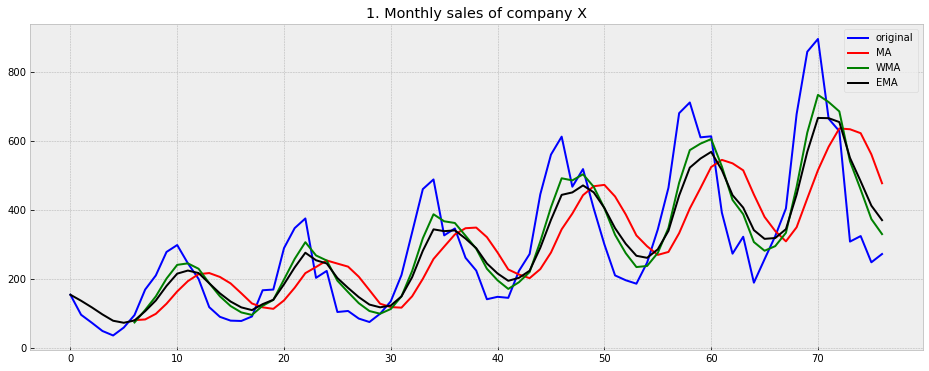

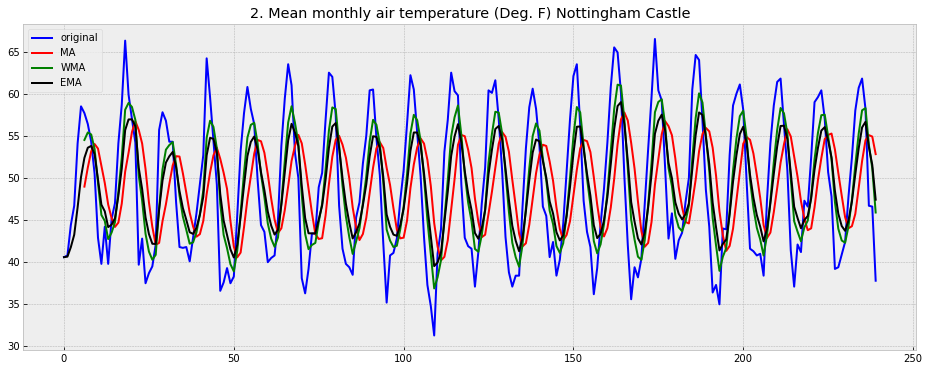

In [171]:
for i, key in enumerate(all_series.keys()):
    series = all_series[key]
    ema = exponential_moving_average(series, 0.3)
    wma = weighted_moving_average(series, 7, [1,1,2,3,5,8,13])
    ma = moving_average(series, 7)
    with plt.style.context('bmh'):
        plt.figure(figsize=(16, 6))
        plt.plot(series, color='blue',label='original')
        plt.plot(ma, color='red', linewidth='2', label='MA')
        plt.plot(wma, color='green', linewidth='2', label='WMA')
        plt.plot(ema, color='black', linewidth='2', label='EMA')
        plt.title(str(i+1) + '. ' + key)
        plt.legend()

<h3> Для прогноза рядов будем использовать несколько моделей,
<h3>по каждой из них рассчитаем метрики качества

In [172]:
df = pd.read_csv("Series/monthly-sales-of-company-x-jan-6.csv")
df2 = pd.read_csv("Series/mean-monthly-air-temperature-deg.csv")
df2.rename(columns = {'Deg':'Count'}, inplace = True )

# переведем месяц в формат DATETIME и сделаем его индексом 
df['Month'] = pd.to_datetime(df['Month'])
df.set_index('Month', inplace=True)
df2['Month'] = pd.to_datetime(df2['Month'])
df2.set_index('Month', inplace=True)

In [173]:
# добавим колонки (сдвиг от 1 до 12 месяцев), удалим пустые строки и оставим года с 12 месяцами
for i in range(12):
    df.loc[:,f'Sh-'+str(i+1)] = df.loc[:,'Count'].shift(i+1)
df = df.dropna()
df =df[:-5]
for i in range(12):
    df2.loc[:,f'Sh-'+str(i+1)] = df2.loc[:,'Count'].shift(i+1)
df2 = df2.dropna()
df2

,Count,Sh-1,Sh-2,Sh-3,Sh-4,Sh-5,Sh-6,Sh-7,Sh-8,Sh-9,Sh-10,Sh-11,Sh-12
Month,,,,,,,,,,,,,
1921-01-01,44.2,39.8,42.9,50.5,54.3,56.4,57.7,58.5,54.1,46.7,44.4,40.8,40.6
1921-02-01,39.8,44.2,39.8,42.9,50.5,54.3,56.4,57.7,58.5,54.1,46.7,44.4,40.8
1921-03-01,45.1,39.8,44.2,39.8,42.9,50.5,54.3,56.4,57.7,58.5,54.1,46.7,44.4
1921-04-01,47.0,45.1,39.8,44.2,39.8,42.9,50.5,54.3,56.4,57.7,58.5,54.1,46.7
1921-05-01,54.1,47.0,45.1,39.8,44.2,39.8,42.9,50.5,54.3,56.4,57.7,58.5,54.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1939-08-01,61.8,60.7,58.0,52.4,47.8,42.4,40.9,39.4,39.2,47.8,50.7,57.0,60.4
1939-09-01,58.2,61.8,60.7,58.0,52.4,47.8,42.4,40.9,39.4,39.2,47.8,50.7,57.0
1939-10-01,46.7,58.2,61.8,60.7,58.0,52.4,47.8,42.4,40.9,39.4,39.2,47.8,50.7


In [174]:
# в качестве теста будем использовать последний год
X_train = df[:'1969-12-01'].drop(['Count'], axis = 1)
y_train = df.loc[:'1969-12-01', 'Count']
X_test = df['1970-01-01':].drop(['Count'], axis = 1)
y_test = df.loc['1970-01-01':, 'Count']

X_train2 = df2[:'1938-12-01'].drop(['Count'], axis = 1)
y_train2 = df2.loc[:'1938-12-01', 'Count']
X_test2 = df2['1939-01-01':].drop(['Count'], axis = 1)
y_test2 = df2.loc['1939-01-01':, 'Count']
y_test

Month
1970-01-01    613
1970-02-01    392
1970-03-01    273
1970-04-01    322
1970-05-01    189
1970-06-01    257
1970-07-01    324
1970-08-01    404
1970-09-01    677
1970-10-01    858
1970-11-01    895
1970-12-01    664
Name: Count, dtype: int64

In [175]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score  
from sklearn.inspection import permutation_importance
models = []
models.append(('LR', LinearRegression(),'b'))
models.append(('Ridge', Ridge(),'r'))
models.append(('NN', MLPRegressor(solver = 'lbfgs',max_iter=7000),'c'))  
models.append(('KNN', KNeighborsRegressor(),'m')) 
models.append(('RF', RandomForestRegressor(n_estimators = 100),'y'))
models.append(('SVR', SVR(gamma='auto',kernel = 'linear'),'k'))

LR: R2 - 0.842282, mse - 8472
Ridge: R2 - 0.842283, mse - 8472
NN: R2 - 0.878589, mse - 6521
KNN: R2 - 0.686495, mse - 16840
RF: R2 - 0.794983, mse - 11012
SVR: R2 - 0.863584, mse - 7327


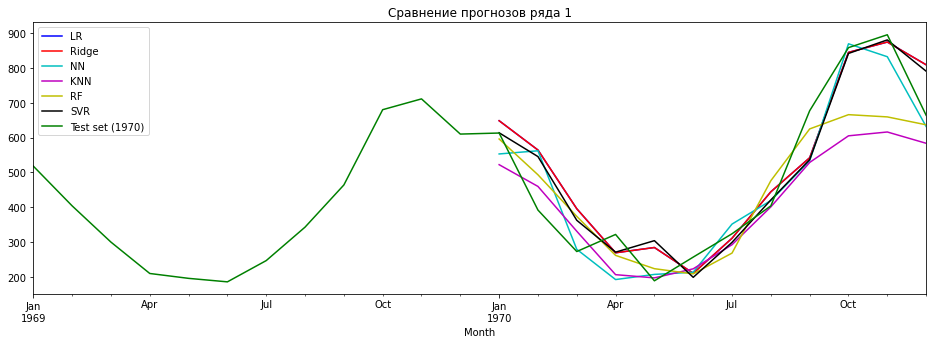

In [176]:
# 1. Оценим 6 моделей по R2 score и MSE для "sales_of_company_x"
for name, model, clr in models:
    model.fit(X_train, y_train)
    r2 = model.score(X_test, y_test)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    df3 = df.copy()[-12:] # прогноз на год
    df3['y_pred']= y_pred
    print('%s: R2 - %f, mse - %.0f' % (name, r2, mse))
    df3['y_pred'].plot(figsize=(16,5),label=name,color=clr)
    plt.legend()

df["Count"]["1969-01-01":].plot(figsize=(16,5),label='Test set (1970)',color='g')
plt.legend()
plt.title('Сравнение прогнозов ряда 1')
plt.show()

LR: R2 - 0.928893, mse - 5
Ridge: R2 - 0.928915, mse - 5
NN: R2 - 0.952235, mse - 3
KNN: R2 - 0.932943, mse - 5
RF: R2 - 0.944934, mse - 4
SVR: R2 - 0.925236, mse - 5


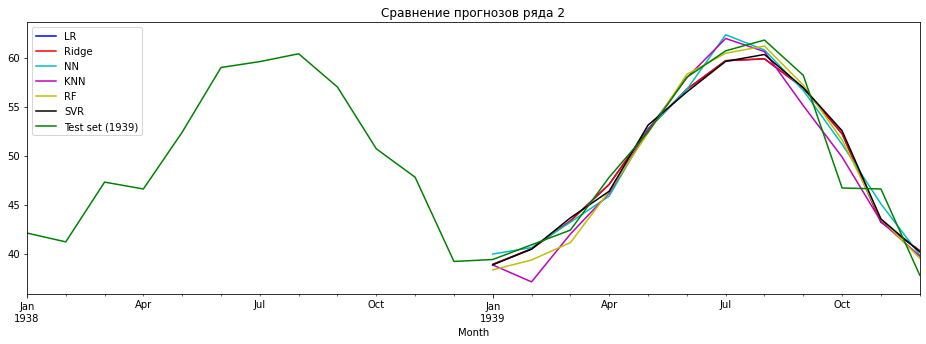

In [177]:
# 2. Оценим 6 моделей по R2 score и MSE для "mean_monthly_temp"
for name, model, clr in models:
    model.fit(X_train2, y_train2)
    r2 = model.score(X_test2, y_test2)
    y_pred = model.predict(X_test2)
    mse = mean_squared_error(y_test2, y_pred)
    df3 = df2.copy()[-12:] # прогноз на год
    df3['y_pred']= y_pred
    print('%s: R2 - %f, mse - %.0f' % (name, r2, mse))
    df3['y_pred'].plot(figsize=(16,5),label=name,color=clr)
    plt.legend()

df2["Count"]["1938-01-01":].plot(figsize=(16,5),label='Test set (1939)',color='g')
plt.legend()
plt.title('Сравнение прогнозов ряда 2')
plt.show()

In [178]:
# Отметим, что точность прогнозирования стационарного ряда 2 значительно лучше показателей нестационарного ряда 1

<h3> Определим важность признаков для RandomForestRegressor

<BarContainer object of 12 artists>

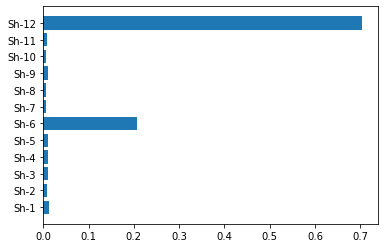

In [179]:
rf = RandomForestRegressor(n_estimators=100)
rf.fit(X_train2, y_train2)
rf.feature_importances_
plt.barh(X_test2.columns, rf.feature_importances_)

# <h4> что подтверждает наличие цикличности

In [180]:

# посмотрим также динамику r2 при кросс-валидации
for i in range(1,17):
    X_train = df2[:12*i].drop(['Count'], axis = 1)
    y_train = df2['Count'][:12*i]
    X_test = df2[12*i:24*i].drop(['Count'], axis = 1)
    y_test = df2['Count'][12*i:24*i]
    rf = RandomForestRegressor()
    rf.fit(X_train, y_train)
    rf_confidence = rf.score(X_test, y_test)
    y_pred = rf.predict(X_test)
    y_pred
    print(rf_confidence)

0.47895175378404176
0.8037133791634807
0.9086744114311816
0.881403009780632
0.8785696133032469
0.9126538704802079
0.9121135707425894
0.9143850080519779
0.920634747045288
0.9189497575204839
0.9173596883035844
0.9228904540976248
0.9225870639507252
0.9242633924964767
0.9240208328550541
0.916770097924249


LR: 0.921374 (0.012717)
Ridge: 0.921403 (0.012692)
NN: 0.791824 (0.103452)
KNN: 0.915696 (0.019069)
RF: 0.910031 (0.015551)
SVR: 0.896520 (0.048583)


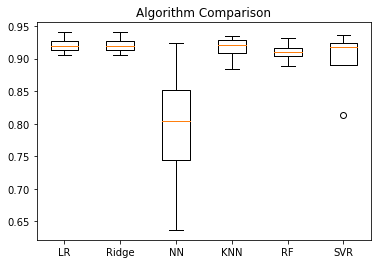

In [181]:
# а также применим кросс-валидацию для всех моделей:
models = []
models.append(('LR', LinearRegression()))
models.append(('Ridge', Ridge()))
models.append(('NN', MLPRegressor(solver = 'lbfgs',max_iter=7000)))  
models.append(('KNN', KNeighborsRegressor())) 
models.append(('RF', RandomForestRegressor(n_estimators = 100)))
models.append(('SVR', SVR(gamma='auto',kernel = 'linear')))
results = []
names = []
for name, model in models:
    # TimeSeries Cross validation
    tscv = TimeSeriesSplit(n_splits=4)
    
    cv_results = cross_val_score(model, X_train, y_train, cv=tscv, scoring='r2')
    results.append(cv_results)
    names.append(name)
    print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))
# Compare Algorithms
plt.boxplot(results, labels=names)
plt.title('Algorithm Comparison')
plt.show()

<h4>Общий вывод: Модели достаточно точно предсказывают циклические графики. При этом результат по стационарным рядам лучше так как уменьшаются потери оценки, связанные с трендом и разбросом данных (дисперсией). Кросс-валидация позволяет повысить результаты. Здесь важным фактором также является количество тестовых отрезков (чем больше, тем лучше). Скользящие средние позволяют наметить линии тренда, в то же время чем больше ширина окна, тем больше получается отклонение точек от реальных данных. 